In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

import cv2
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully!")

All libraries imported successfully!


Dataset shape: (35887, 3)

First 5 rows:
   emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

Emotion distribution:
emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64


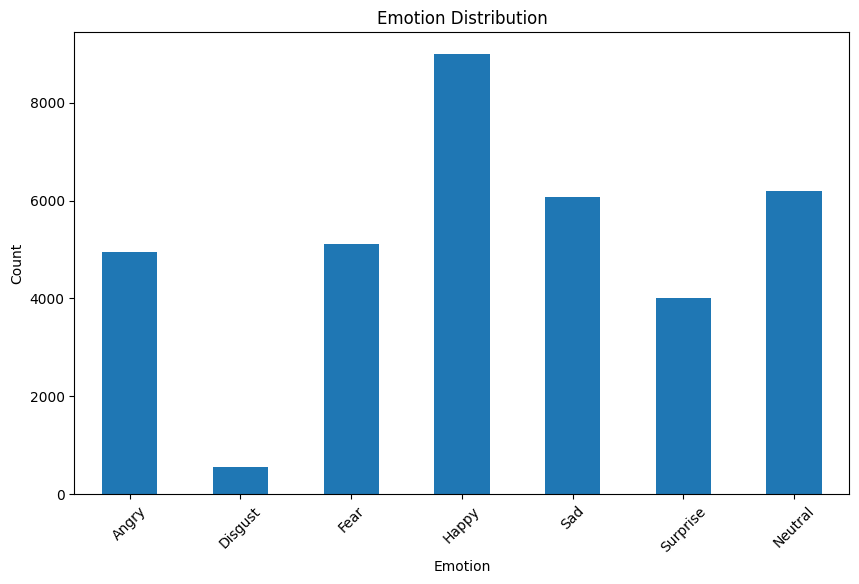

In [2]:
# Load FER2013 dataset
data = pd.read_csv('../data/fer2013.csv')

print("Dataset shape:", data.shape)
print("\nFirst 5 rows:")
print(data.head())

print("\nEmotion distribution:")
print(data['emotion'].value_counts())

# Emotion labels
emotion_labels = {
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprise',
    6: 'Neutral'
}

plt.figure(figsize=(10, 6))
data['emotion'].value_counts().sort_index().plot(kind='bar')
plt.title('Emotion Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.xticks(range(7), [emotion_labels[i] for i in range(7)], rotation=45)
plt.show()

In [3]:
# Convert string pixels to numpy arrays
def preprocess_data(data):
    pixels = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32'))
    pixels = np.stack(pixels, axis=0)
    pixels = pixels.reshape(-1, 48, 48, 1)
    pixels = pixels / 255.0  # Normalize
    
    emotions = to_categorical(data['emotion'])
    
    return pixels, emotions

# Preprocess data
X, y = preprocess_data(data)

print("Input shape:", X.shape)
print("Output shape:", y.shape)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Input shape: (35887, 48, 48, 1)
Output shape: (35887, 7)
Training set: (22967, 48, 48, 1)
Validation set: (5742, 48, 48, 1)
Test set: (7178, 48, 48, 1)


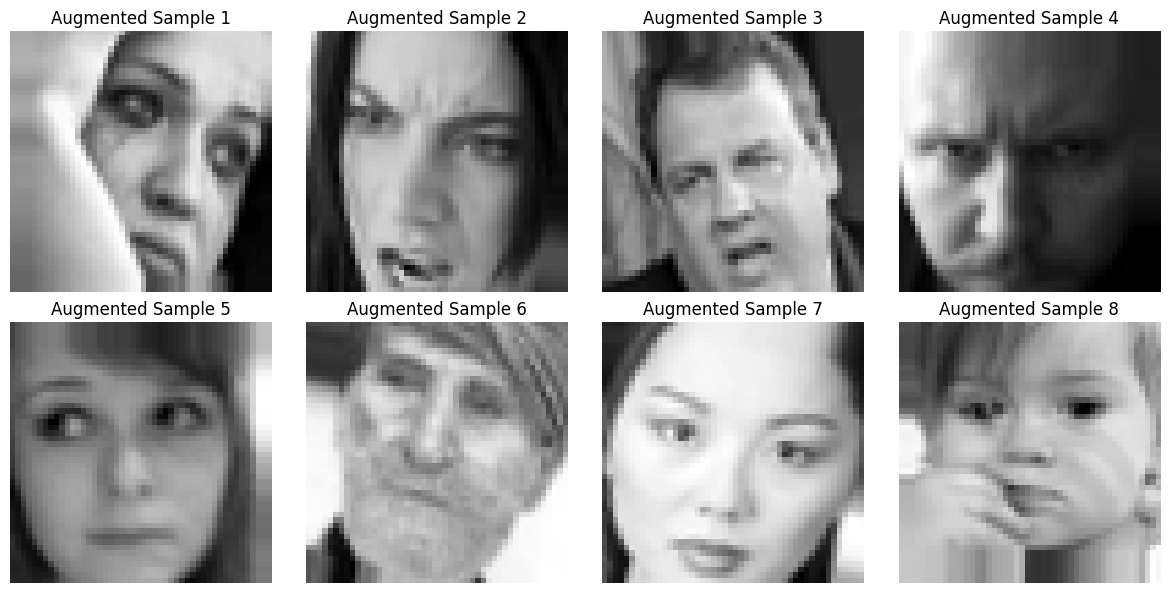

In [4]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

datagen.fit(X_train)

# Visualize some augmented images
plt.figure(figsize=(12, 6))
for i in range(8):
    plt.subplot(2, 4, i+1)
    batch = next(datagen.flow(X_train, y_train, batch_size=1))
    plt.imshow(batch[0][0].reshape(48, 48), cmap='gray')
    plt.title(f'Augmented Sample {i+1}')
    plt.axis('off')
plt.tight_layout()
plt.show()

In [5]:
def create_emotion_model():
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Second Convolutional Block
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Third Convolutional Block
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))
    
    return model

# Create model
model = create_emotion_model()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 18, 18, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 687,079 (2.62 MB)

 Trainable params: 684,647 (2.61 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [6]:
# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7),
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
]

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 172s 449ms/step - accuracy: 0.2029 - loss: 2.2846 - val_accuracy: 0.2640 - val_loss: 1.8564 - learning_rate: 0.0010
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 151s 421ms/step - accuracy: 0.2658 - loss: 1.8262 - val_accuracy: 0.3152 - val_loss: 1.7047 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 202s 421ms/step - accuracy: 0.3283 - loss: 1.6896 - val_accuracy: 0.4161 - val_loss: 1.5000 - learning_rate: 0.0010
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 157s 436ms/step - accuracy: 0.3728 - loss: 1.5983 - val_accuracy: 0.4225 - val_loss: 1.4862 - learning_rate: 0.0010
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 189s 400ms/step - accuracy: 0.4114 - loss: 1.5143 - val_accuracy: 0.3817 - val_loss: 1.6111 - learning_rate: 0.0010
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 150s 419ms/step - accuracy: 0.4385 - loss: 1.4497 - val_accuracy: 0.4960 - val_loss: 1.3240 - learning_rate: 0.0010
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 153s 425ms/step -

Test Accuracy: 0.6344
Test Loss: 0.9647


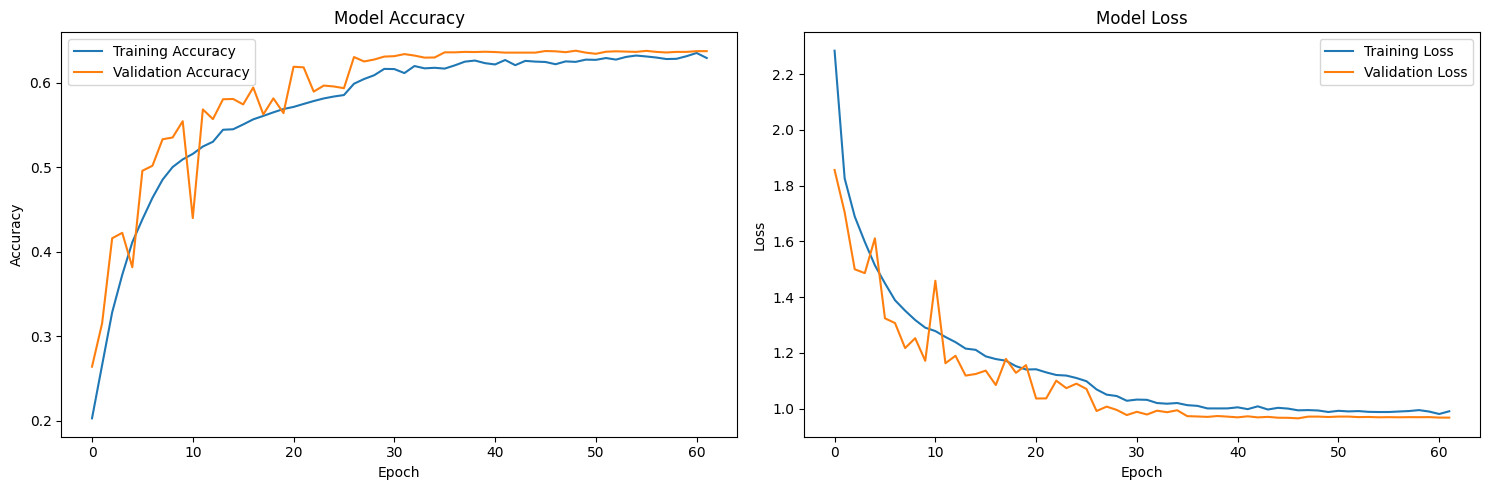

In [7]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Loss plot
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

225/225 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step
Classification Report:
              precision    recall  f1-score   support

       Angry       0.57      0.57      0.57       985
     Disgust       0.55      0.25      0.35       102
        Fear       0.51      0.32      0.39      1043
       Happy       0.86      0.85      0.85      1765
         Sad       0.52      0.50      0.51      1210
    Surprise       0.73      0.76      0.74       795
     Neutral       0.54      0.73      0.62      1278

    accuracy                           0.63      7178
   macro avg       0.61      0.57      0.58      7178
weighted avg       0.63      0.63      0.63      7178



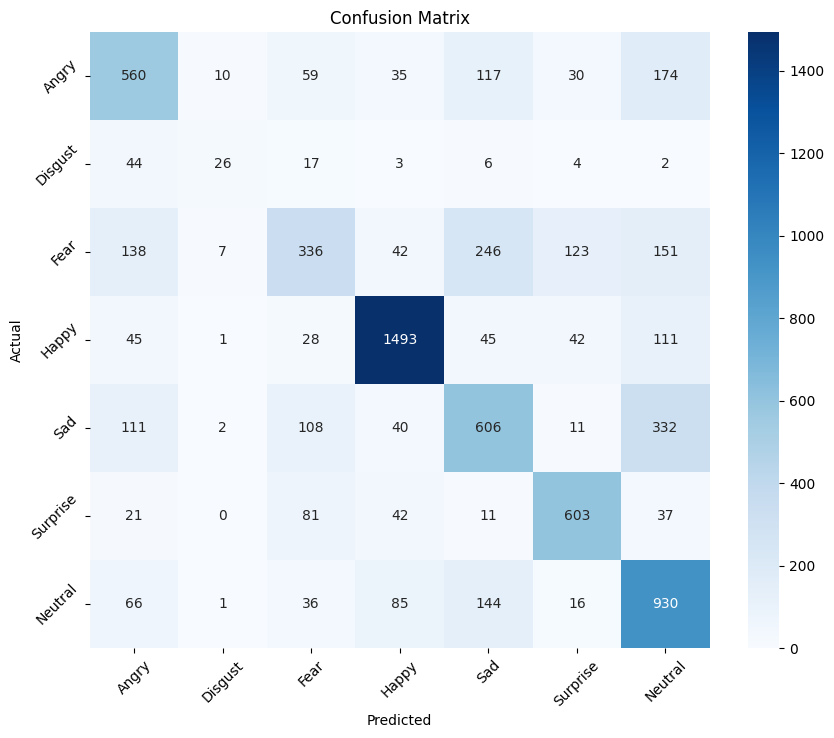

In [8]:
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Classification report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=[emotion_labels[i] for i in range(7)]))

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[emotion_labels[i] for i in range(7)],
            yticklabels=[emotion_labels[i] for i in range(7)])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.show()

In [13]:
# Cell 9: Save Model and Labels (Clean version - no warnings)
# Save the model in the modern Keras format
model.save('emotion_model.keras')
print(" Model saved successfully as 'emotion_model.keras'!")

# Save emotion labels
import json
with open('emotion_labels.json', 'w') as f:
    json.dump(emotion_labels, f)
print(" Emotion labels saved as 'emotion_labels.json'!")

# Print model file size
import os
if os.path.exists('emotion_model.keras'):
    size = os.path.getsize('emotion_model.keras') / (1024 * 1024)  # MB
    print(f" Model file size: {size:.2f} MB")

print(" Model training completed successfully!")
print(" You can now run the web app with: streamlit run src/app.py")

 Model saved successfully as 'emotion_model.keras'!
 Emotion labels saved as 'emotion_labels.json'!
 Model file size: 7.96 MB
 Model training completed successfully!
 You can now run the web app with: streamlit run src/app.py
